In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os 
import pandas as pd
from matplotlib.lines import Line2D
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
import ast
from config import Scenarios
from ParametricGraphModels.ADC_SBM import from_config
from tqdm import tqdm 

In [2]:
print(os.listdir(os.path.join(os.getcwd(),"ExperimentLogs")))

['Final100']


In [3]:
last_exp = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Final100"

In [6]:
def load_all_pickles(directory:str, model: str, graphtype: str, num_obs:int=100) -> list:
    """
    Iterates over all pickle files (results of the simulation) in the specified directory and loads them.
    
    :param directory: "C:\\Users\zogaj\PycharmProjects\MA\ExperimentLogs\_____"
    :param model: ["GCN", "GAT", "SAGE", "MLP"]
    :param graphtype: scneraio 1 - 6
    :param num_obs: How many MC runs to load. (Full range default). 
    :return: 
    """
    loaded_objects = []
    final_path = os.path.join(directory, model, graphtype)
    
    for i, filename in enumerate(os.listdir(final_path)):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
        if i == num_obs - 1:
            return loaded_objects
        
    return loaded_objects
    

## Store the results of all Model/Scenario Combinations 

In [7]:
# Graphtype must match with the names specified in config.py 
gcn_perfect = load_all_pickles(last_exp, "GCN", "perfect")
gat_perfect = load_all_pickles(last_exp, "GAT", "perfect")
sage_perfect = load_all_pickles(last_exp, "SAGE", "perfect") 
mlp_perfect = load_all_pickles(last_exp, "MLP", "perfect")

gcn_com = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant")
gat_com = load_all_pickles(last_exp, "GAT", "community_relevant")
sage_com = load_all_pickles(last_exp, "SAGE", "community_relevant") 
mlp_com = load_all_pickles(last_exp, "MLP", "community_relevant")

gcn_com_h = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_heterophilic")
gat_com_h = load_all_pickles(last_exp, "GAT", "community_relevant_heterophilic")
sage_com_h = load_all_pickles(last_exp, "SAGE", "community_relevant_heterophilic") 
mlp_com_h = load_all_pickles(last_exp, "MLP", "community_relevant_heterophilic")


gcn_feat = load_all_pickles(directory=last_exp,model="GCN",graphtype="cluster_relevant")
gat_feat = load_all_pickles(last_exp, "GAT", "cluster_relevant")
sage_feat = load_all_pickles(last_exp, "SAGE", "cluster_relevant") 
mlp_feat = load_all_pickles(last_exp, "MLP", "cluster_relevant")

gcn_feat_p = load_all_pickles(directory=last_exp,model="GCN",graphtype="non_seperated_cluster_relevant")
gat_feat_p = load_all_pickles(last_exp, "GAT", "non_seperated_cluster_relevant")
sage_feat_p = load_all_pickles(last_exp, "SAGE", "non_seperated_cluster_relevant") 
mlp_feat_p = load_all_pickles(last_exp, "MLP", "non_seperated_cluster_relevant")

gcn_noise = load_all_pickles(directory=last_exp,model="GCN",graphtype="noise")
gat_noise = load_all_pickles(last_exp, "GAT", "noise")
sage_noise = load_all_pickles(last_exp, "SAGE", "noise") 
mlp_noise = load_all_pickles(last_exp, "MLP", "noise")


In [8]:
package = np.array([[gcn_perfect, gcn_com, gcn_com_h,
                     gcn_feat, gcn_feat_p, gcn_noise],  
                    [gat_perfect, gat_com, gat_com_h, 
                     gat_feat, gat_feat_p, gat_noise],  
                    [sage_perfect, sage_com, sage_com_h,
                     sage_feat, sage_feat_p, sage_noise],  
                    [mlp_perfect, mlp_com, mlp_com_h,
                     mlp_feat, mlp_feat_p, mlp_noise]])

n_scenarios = package.shape[1]
print(n_scenarios)

colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"] 

6


**package** is a nested array of list where all results are stored in dictionaries. <br>
The outer loop accesses the model, the inner loop the graph scenario trained for that model. (4x6) 

# Plot 

In [9]:
def plot_with_confidence_interval(target, color, add_final_epoch,
                                  key="loss_track", empirical_CI=True, ax=None,
                                  percentiles=5):
    """
    Plots figure for one Scenario in specified axis.
    :param target: Results of the scenario.
    :param color: Color for scenario mapping.
    :param add_final_epoch: returns point of early stoppings
    :param key: Key to extract values from target. (loss, val_accuracy, times) 
    :param empirical_CI: Boolean to use empirical confidence interval.
    :param ax: Axis object to plot on.
    :param percentiles: Range of the CI's
    :return: None
    """
    ys = np.array([lp[key][:-1] for lp in target])  # loss-values @ epoch
    
    final_epochs = np.array([lp["final_epoch"] for lp in target])
    nna = sum([0 if x else 1 for x in final_epochs])  # number of non-convergence 
    
    if key=="epoch_times": 
        mean_ys = np.cumsum(np.mean(ys, axis=0))
        avg_final_epoch = np.mean(ys)
        final_epochs = [0]  #placeholder
    else:
        final_epochs = np.where(final_epochs == None, np.nan, final_epochs)
        avg_final_epoch = np.nanmean(final_epochs)
        mean_ys = np.mean(ys, axis=0)
    
    std_ys = np.sqrt(np.var(ys, axis=0)) 

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(1, len(mean_ys)+1)
    
    ax.plot(x, mean_ys, color=color, linewidth=1.5)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.1) if empirical_CI==True else None
    if add_final_epoch in ["val_acc_track", "loss_track"]:
        ax.axvline(x=avg_final_epoch, color=color, linestyle='--')
    
    return avg_final_epoch, nna, min(final_epochs), max(final_epochs)



### Loss/Validation Accuracy - Curves

In [10]:
def plot_epoch_curves(l_o_a, lims):
    
    arch = ["GCN", "GAT", "SAGE", "MLP"]
    colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
    axes = axes.flatten()  
    
    early_stops = np.zeros((5, n_scenarios + 1))
    minmax = np.empty((5, n_scenarios + 1), dtype="U64")
     
    NNA = np.zeros((5, n_scenarios + 1))
    labels = np.arange(n_scenarios) + 1
    
    for i, (model, ax) in enumerate(zip(package, axes)):
        for j, (target, label, color) in enumerate(zip(model, labels, colors)):
            early_stops[i, j], NNA[i, j],MIN,MAX = plot_with_confidence_interval(target, color, key=l_o_a,
                                                                         empirical_CI=True, ax=ax,
                                                                         percentiles=5,
                                                                         add_final_epoch=l_o_a)
            minmax[i, j] = str(MIN) + "-" + str(MAX)

            ax.axhline(y=0.2, color='grey', linestyle='--') if l_o_a == "val_acc_track" else None
            ax.plot([], [], color=color, label=label)  
    
        ax.set_xlabel('Epoch')
        
        if l_o_a == "loss_track":
            ax.set_ylabel('Average Loss')
        elif l_o_a == "val_acc_track":
            ax.set_ylabel('Average Validation Accuracy')
        else:
            ax.set_ylabel('Seconds')
                
        ax.set_ylim(*lims) #  if l_o_a == "val_acc_track" else ax.set_ylim(0, 2) 
        ax.set_title(f'{arch[i]}')
        

    handles = [Line2D([0], [0], color=color, lw=4) for color in colors]  # Farben unterscheiden 
    fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')
        
    early_stops[-1,0:-1] = np.mean(early_stops[:-1, :-1], axis=0)  # row-wise average
    early_stops[0:-1,-1] = np.mean(early_stops[:-1,:-1], axis=1)  # col-wise average
    
    plt.tight_layout()
    plt.show()
    
    return early_stops


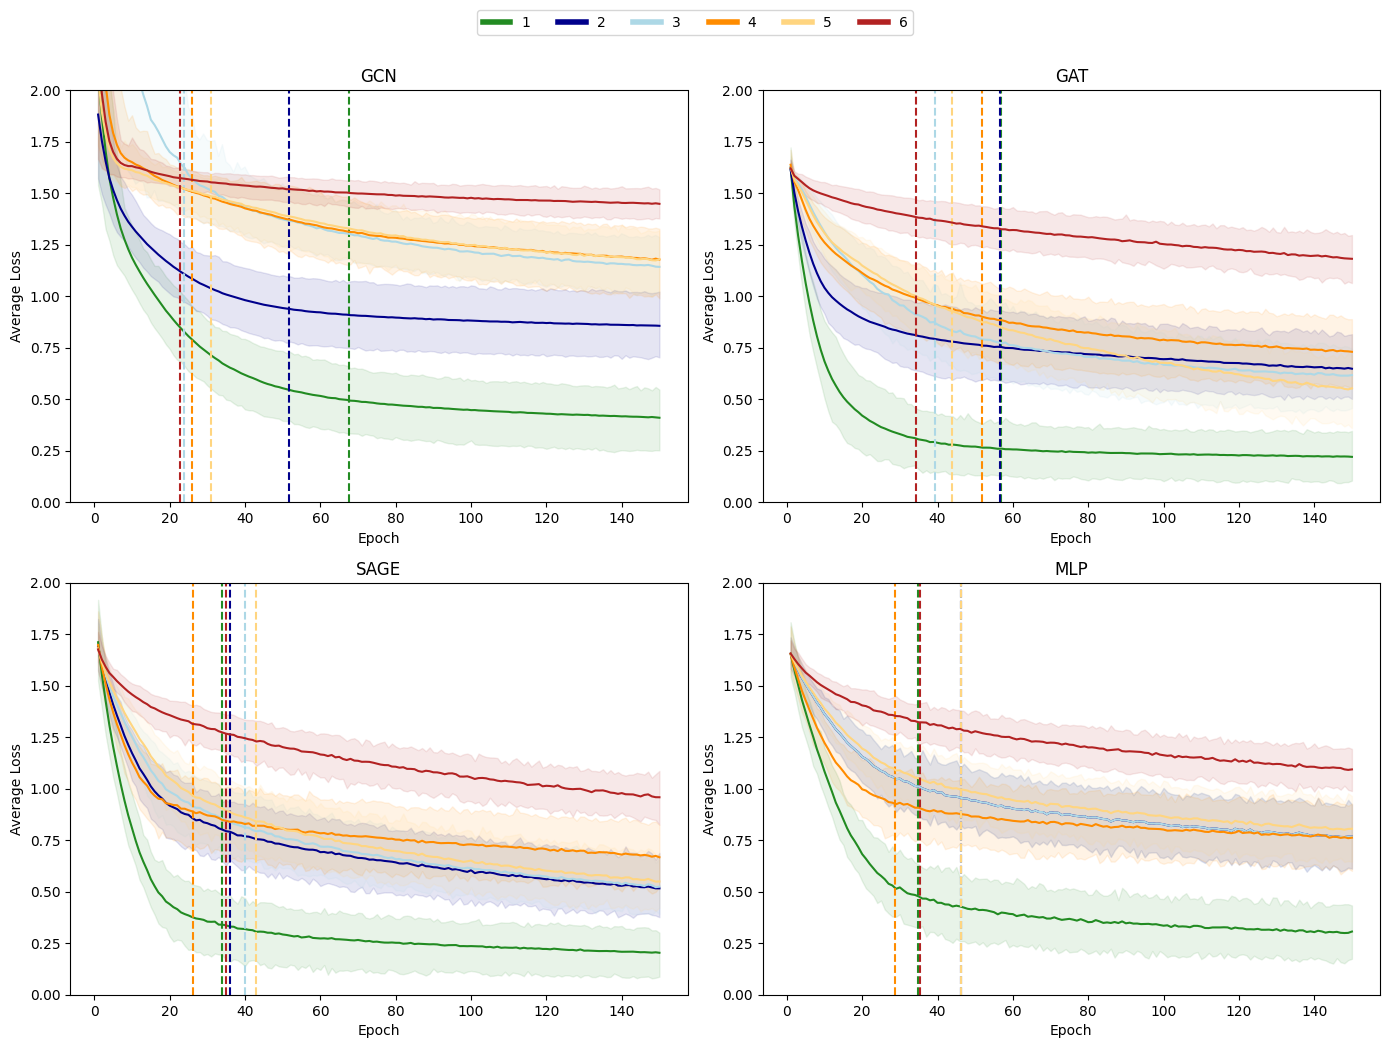

In [11]:
early_stops = plot_epoch_curves("loss_track", (0,2))

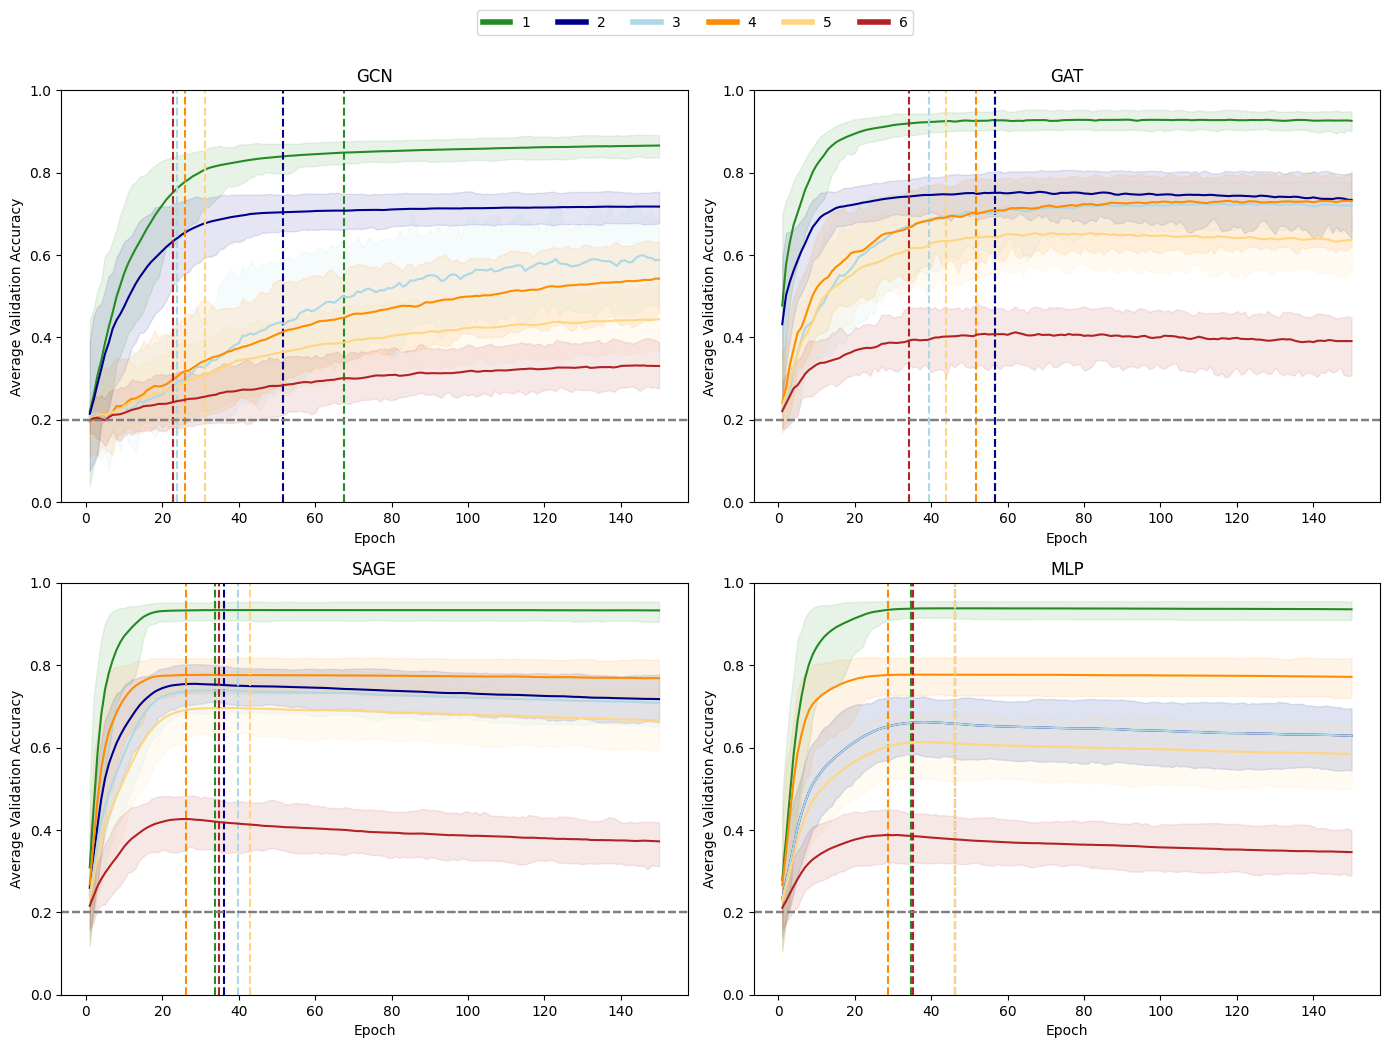

In [12]:
_ = plot_epoch_curves("val_acc_track", (0,1))

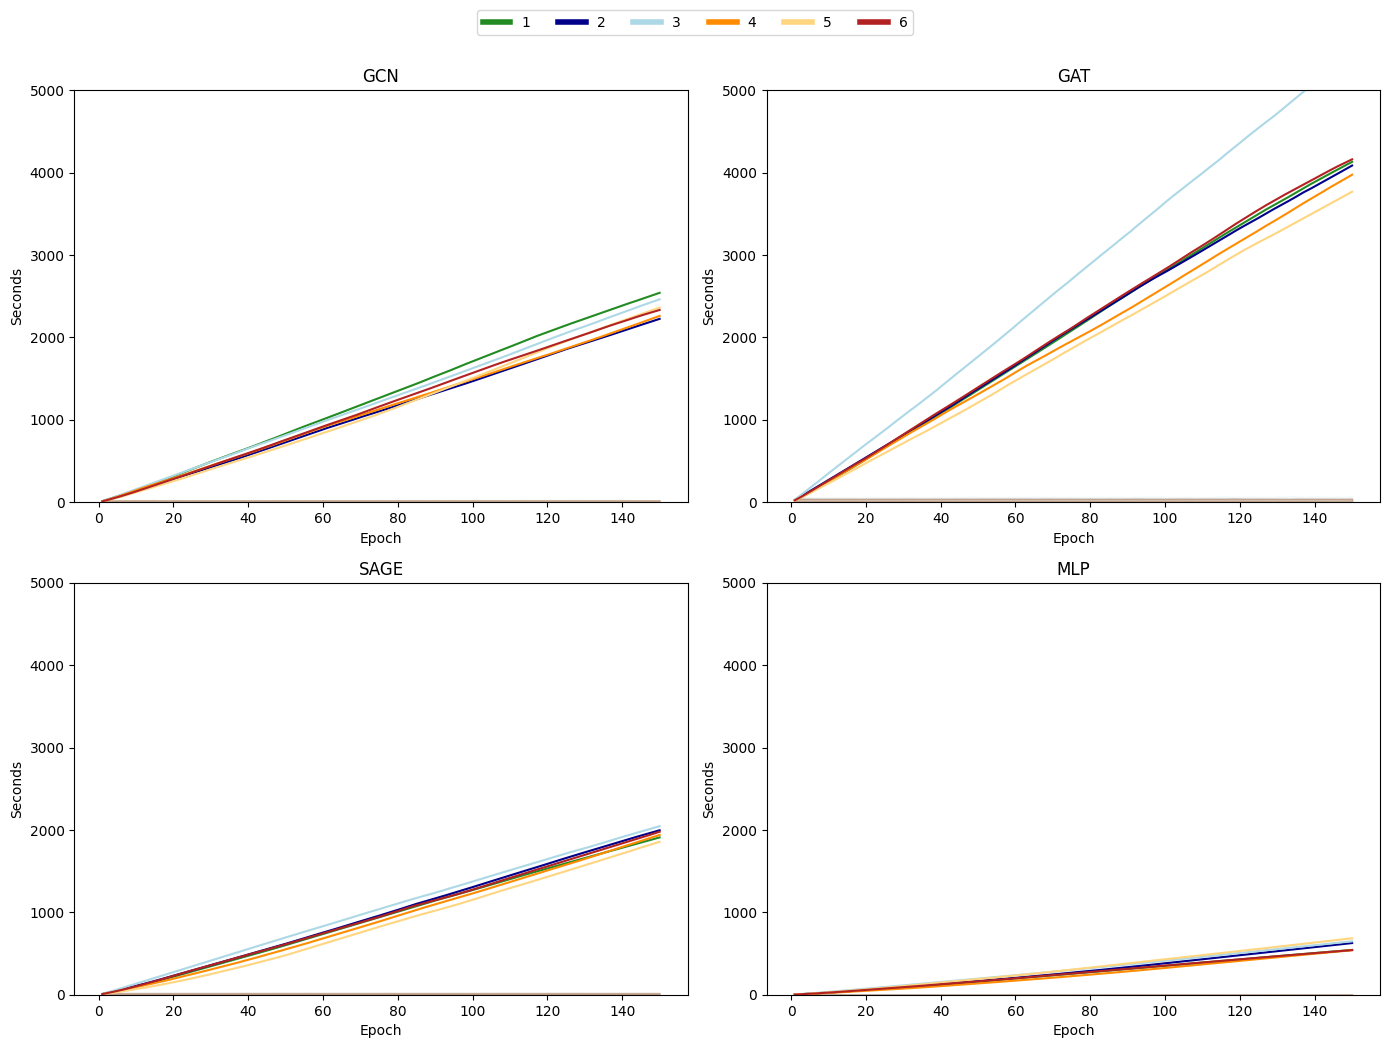

In [13]:
times = plot_epoch_curves("epoch_times", (0, 5000))  # Time plot not relevant 

In [14]:
print(np.round(early_stops, 2))
print(np.mean(early_stops[:-1,-1]))

[[67.56 51.58 23.87 25.86 31.06 22.74 37.11]
 [56.75 56.61 39.36 51.77 43.97 34.18 47.11]
 [33.83 36.06 39.91 26.3  42.87 34.86 35.64]
 [34.81 46.25 46.25 28.81 46.31 35.28 39.62]
 [48.24 47.62 37.35 33.18 41.05 31.76  0.  ]]
39.86856481481481


In [17]:
print(np.round(times, 2))
print(np.mean(times[:-1,-1]))

[[16.95 14.84 16.42 15.08 15.75 15.56 15.77]
 [27.54 27.25 36.34 26.51 25.13 27.75 28.42]
 [12.73 13.31 13.64 12.93 12.38 13.19 13.03]
 [ 3.63  4.18  4.32  3.61  4.57  3.61  3.99]
 [15.21 14.89 17.68 14.53 14.46 15.03  0.  ]]
15.30040449525184


### Final Test accuracies 

In [18]:
mus = np.zeros((4, n_scenarios))  # models (i) x scenarios (j)
sigs = np.empty((4, n_scenarios), dtype="U64")  
upper_lower = lambda x, p : (round(np.percentile(x, p, axis=0), 3), round(np.percentile(x, 100-p, axis=0), 3))
normal = np.empty((4, n_scenarios), dtype="U8")  

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        
        mus[i, j] += np.round(np.mean(accs), 3)
        #sigs[i, j] += np.round(np.sqrt(np.var(accs)), 3)
        sigs[i, j] = str(upper_lower(accs, 5))
        _, p = stats.shapiro(accs)  
        normal[i, j] = "*" if p < .05 else ""
        
result = np.array([[f'{a} {b} {c}' for a, b, c in zip(row_A, row_B, row_C)]
                   for row_A, row_B, row_C in zip(mus, sigs, normal)])        

result = pd.DataFrame(result,
                      index=["GCN", "GAT","SAGE","MLP"],
                      columns=["Perfect", "com", "com_h",
                               "feat", "feat_p", "noise"])
result
#normal < .05

,Perfect,com,com_h,feat,feat_p,noise
GCN,"0.825 (0.585, 0.887) *","0.681 (0.554, 0.752) *","0.265 (0.158, 0.455) *","0.294 (0.16, 0.489) *","0.288 (0.18, 0.47) *","0.237 (0.176, 0.314) *"
GAT,"0.924 (0.893, 0.953) *","0.743 (0.69, 0.795)","0.642 (0.414, 0.772) *","0.678 (0.498, 0.77) *","0.62 (0.528, 0.7)","0.379 (0.3, 0.45)"
SAGE,"0.932 (0.906, 0.955)","0.747 (0.698, 0.797)","0.731 (0.677, 0.787)","0.771 (0.725, 0.817)","0.689 (0.62, 0.752)","0.417 (0.347, 0.48)"
MLP,"0.934 (0.908, 0.957) *","0.654 (0.578, 0.722)","0.654 (0.578, 0.722)","0.772 (0.727, 0.817)","0.608 (0.53, 0.678)","0.386 (0.319, 0.447)"


In [19]:
np.mean(mus[0:3, 1]-mus[-1,1])  # GNN's compared to MLP in scenario 2

0.06966666666666665

In [21]:
def intervals_overlap(interval1, interval2):
    start1, end1 = ast.literal_eval(interval1)
    start2, end2 = ast.literal_eval(interval2)
    return max(start1, start2) <= min(end1, end2)

ccs = [(0,1), (1,2), (0,3), (3,4), (2,5), (4,5)]
deltas = np.empty((4,6), dtype="U32")

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]

    for j, tup in enumerate(ccs): 

        l1 = [s["test_accuracy"] for s in model[tup[0]]]
        l2 = [s["test_accuracy"] for s in model[tup[1]]]

        _, p_mwu = mannwhitneyu(l1, l2, alternative='two-sided') # H0: medians are same rejected by p <0.5

        _, p_tt = ttest_ind(l1, l2, equal_var=False) # H0: means are same rejected by p <0.5
        cio = int(intervals_overlap(sigs[i, tup[0]],
                                    sigs[i ,tup[1]]))
        
        deltas[i, j] = str(round(p_mwu, 3)) + "<|" + str(cio) + "|"+ str(round(p_tt, 3))

deltas  # p-value for MWU test, Overlapps or not, p-value for t-test 

array([['0.0<|1|0.0', '0.0<|0|0.0', '0.0<|0|0.0', '0.887<|1|0.672',
        '0.375<|1|0.013', '0.0<|1|0.0'],
       ['0.0<|0|0.0', '0.0<|1|0.0', '0.0<|0|0.0', '0.0<|1|0.0',
        '0.0<|1|0.0', '0.0<|0|0.0'],
       ['0.0<|0|0.0', '0.001<|1|0.001', '0.0<|0|0.0', '0.0<|1|0.0',
        '0.0<|0|0.0', '0.0<|0|0.0'],
       ['0.0<|0|0.0', '1.0<|1|1.0', '0.0<|0|0.0', '0.0<|0|0.0',
        '0.0<|0|0.0', '0.0<|0|0.0']], dtype='<U32')

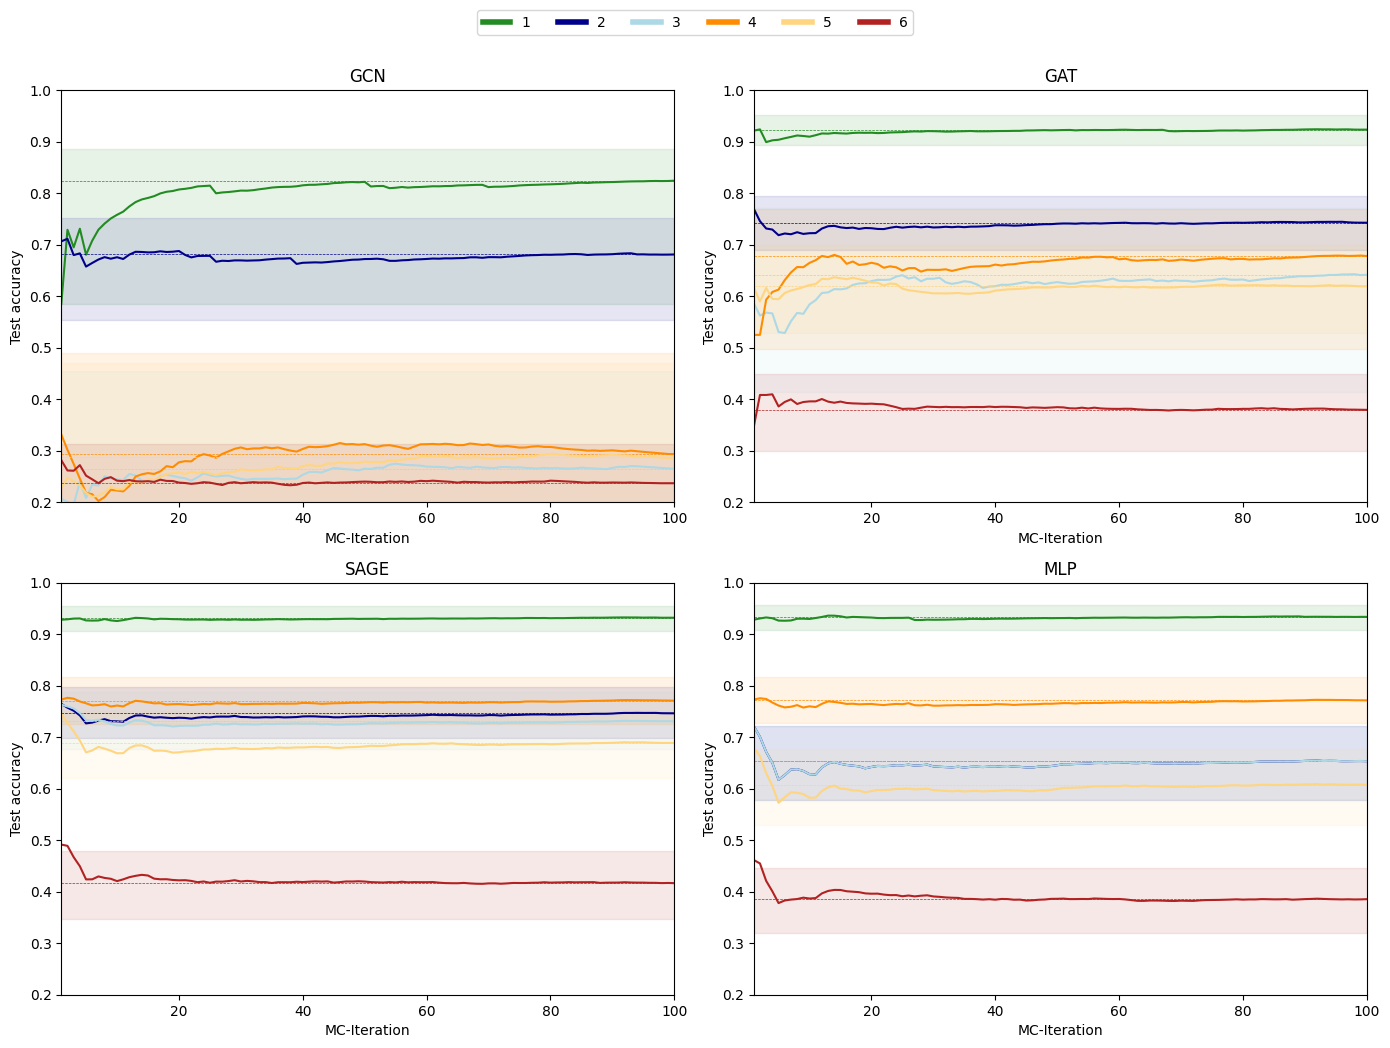

array([[25., 25., 71., 43., 33., 15.],
       [16., nan, 23., 31., 44., 27.],
       [ 7., 11., 18., 28., 18., 21.],
       [ 7., 23., 23., 20., 23., 18.]])

In [22]:
def MC_check_convergence(x: any, eps: float, consec:int) -> int | None: 
    """
    
    :param x: 1 dimensional array
    :param eps: stoppage criterion 
    :return: Index of convergence, or None if not converged  
    """
    count = 0
    for i, e in enumerate(np.diff(x, 1)): #  [0, 1, 2, ..., 100]
        
        if abs(e) < eps:
            count += 1 
        elif count == consec:  # consecutevily smaller 
            return i + 1
        else:
            count = 0


def MCR_plot(target:dict, color:str, ax=None):
    """
    :param target: a dictionary of length R (here 50).
    :param color: color for scenarios
    :param ax: default 
    :return: 
    """
    ys = [lp["test_accuracy"] for lp in target]  # 1-dim Array of size R 
    r_avg = np.cumsum(ys) / np.arange(1, len(ys) + 1)
    
    x = np.arange(1, len(ys) + 1)
    u, l = upper_lower(ys, 5)
    #mean_ys, std_ys = np.mean(ys), np.sqrt(np.var(ys, axis=0))
    #u, l = mean_ys + (1.96 * std_ys), mean_ys - (1.96 * std_ys)

    ax.plot(x, r_avg, color=color)
    ax.axhline(np.mean(ys), color=color, linestyle='--', linewidth=.5)
    ax.fill_between(x, u, l, color=color, alpha=0.1)
        
    return MC_check_convergence(r_avg, .001, 2)
        
arch = ["GCN", "GAT", "SAGE", "MLP"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

labels = np.arange(n_scenarios) + 1
converged_at = np.zeros((4, n_scenarios))

for i, (model, ax) in enumerate(zip(package, axes)):  #[[GCN_1,...], [GAT_1,...],...]
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):  # [1, 2, ...]
        converged_at[i, j] = MCR_plot(target, color, ax=ax)
        ax.plot([], [], color=color, label=label) 

    ax.set_xlabel('MC-Iteration')
    ax.set_ylim(.2, 1)
    ax.set_xlim(1, 100)
    ax.set_ylabel('Test accuracy')
    
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()
converged_at


# Graph Characteristics 

In [23]:
def load_all_pickles_char(directory:str, graphtype: str, num_obs:int=100) -> list:
    """
     Iterates over all pickle files in the specified directory and loads them.
    :param directory: 
    :param graphtype: 
    :param num_obs: 
    :return: 
    """
    loaded_objects = []
    final_path = os.path.join(directory, "GraphCharacteristics", graphtype)
    
    # Iterate over all files in the directory
    for i, filename in enumerate(os.listdir(final_path)):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
        if i == num_obs-1:
            return loaded_objects
    
    return loaded_objects
 

In [24]:
perfect = load_all_pickles_char(directory=last_exp,graphtype="perfect")
community_relevant = load_all_pickles_char(directory=last_exp,graphtype="community_relevant")
community_relevant_h = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_heterophilic")
cluster_relevant = load_all_pickles_char(directory=last_exp,graphtype="cluster_relevant")
cluster_relevant_p = load_all_pickles_char(directory=last_exp,graphtype="non_seperated_cluster_relevant")
noise = load_all_pickles_char(directory=last_exp,graphtype="noise")

package2 = np.array(([perfect, community_relevant, community_relevant_h,
                      cluster_relevant, cluster_relevant_p, noise]))

n_scenarios = package2.shape[0]
n_scenarios

6

In [25]:
def cor_table(pckg, n_scenarios, col_names):
    nks = 3  # Nachkommastellen 
    mus = np.zeros((3, n_scenarios))  
    sigs = np.empty((3, n_scenarios), dtype="U64")  
    normal = np.empty((4, n_scenarios), dtype="U8")
    
    upper_lower = lambda x, p, i : str((round(np.percentile(x, p, axis=0), i), round(np.percentile(x, 100-p, axis=0), i)))
    
    for k, m in enumerate(["h", "h_hat", "wilks_lambda"]):
        for i, s in enumerate(pckg): # package4 or 2
            y = np.array([acc[m][0] for j, acc in enumerate(s)]) if m == "wilks_lambda" \
                else np.array([acc[m] for j, acc in enumerate(s)])
    
            mtrc = np.mean(y) if m in ["h", "h_hat"] else np.mean(1-y)
            _, p = stats.shapiro(y)   
            normal[k, i] = "*" if p < .05 else ""
            
            mus[k, i] += np.round(mtrc, 3)
            sigs[k, i] = str(upper_lower(y, 5, nks)) if m in ["h", "h_hat"] else str(upper_lower(1-y, 5, nks))
        
   
        result = np.array([[f'{a} {b} {c}' for a, b, c in zip(row_A, row_B, row_C)]
                   for row_A, row_B, row_C in zip(mus, sigs, normal)])      
        
        result = pd.DataFrame(result,
                              index=["h","h^", "L"],
                              columns=col_names)
    
    return result

cor_table(package2, 6 ,["Perfect", "com", "com_h", "feat", "feat_p", "noise"])

C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,Perfect,com,com_h,feat,feat_p,noise
h,"0.669 (0.646, 0.688)","0.503 (0.465, 0.538)","0.1 (0.087, 0.113)","0.201 (0.199, 0.203)","0.201 (0.199, 0.203)","0.21 (0.208, 0.213)"
h^,"0.586 (0.557, 0.609)","0.377 (0.327, 0.421)","0.0 (0.0, 0.0)","0.001 (0.0, 0.001) *","0.001 (0.0, 0.001) *","0.012 (0.009, 0.014)"
L,"0.777 (0.692, 0.842) *","0.297 (0.171, 0.4)","0.297 (0.171, 0.4)","0.495 (0.393, 0.568) *","0.259 (0.136, 0.355)","0.086 (0.05, 0.123)"


In [ ]:
for k, m in enumerate(["wilks_lambda"]):
    for i, s in enumerate(package2):
        y = np.array([acc[m][1] for j, acc in enumerate(s)]) 
        print(y)


### Class balances 

In [39]:
res = np.zeros((5,6))  # 5 classes
for i, scen in enumerate(package2):
    res[:,i] = np.round(np.mean([r["class_balance"] for r in scen], axis=0),2)

row_avgs = res.mean(axis=1)  # Average across rows
col_avgs = res.mean(axis=0)  # Average across columns

res_with_row_avgs = np.column_stack((res, row_avgs))
res_with_avgs = np.vstack((res_with_row_avgs, np.append(col_avgs, np.nan)))  # Use NaN for the last cell

pd.DataFrame(res_with_avgs)

,0,1,2,3,4,5,6
0,597.24,591.97,591.97,591.97,591.97,591.66,592.796667
1,599.99,602.14,602.14,602.14,602.14,600.18,601.455000
2,603.30,606.95,606.95,606.95,606.95,606.78,606.313333
3,596.40,592.98,592.98,592.98,592.98,597.02,594.223333
4,603.07,605.96,605.96,605.96,605.96,604.36,605.211667
5,600.00,600.00,600.00,600.00,600.00,600.00,NaN


In [26]:
def create_scatter_data(scens, caracs, n_scenarios, R):
    """
    :param scens: either "package" or "package3"
    :param caracs: either "package2" or "package4"
    :param n_scenarios: 5 or 6 
    :param R: 50
    :return: 
    """
    Y = np.zeros((4,n_scenarios,R))
    rs = Y.shape[1] * Y.shape[2]  # number of scenarios times number of MC iterations 
    
    for i, model in enumerate(scens): #[[GCN,...], [GAT,...],...]
        for j, scen in enumerate(model): # [1, 2, 3, 4, 5, ...]
            accs = [acc["test_accuracy"] for acc in scen] 
            Y[i,j,:] = accs
    
    # flatten row-wise and reshap to fit the dimensions of training outputs 
    x1 = np.array([[g["h_hat"] for g in c] for c in caracs]).flatten().reshape(rs)
    x2 = np.array([[g["wilks_lambda"][0]for g in c] for c in caracs]).flatten().reshape(rs)
    
    
    return Y, x1, (1-x2)

Y, x1, x2 = create_scatter_data(package, package2, 6, 100)  

In [27]:
def plot_scatter_relation(X, y, colors, xlab, R):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    model_names = ["GCN", "GAT", "SAGE", "MLP"]

    color_labels = np.arange(1, len(colors) + 1)

    for i, ax in enumerate(axs.flatten()):

        repeated_colors = np.repeat(colors, R)
        sc = ax.scatter(X, y[i, :, :].flatten(), color=repeated_colors,s=2)
        
        coef = np.polyfit(X, y[i, :, :].flatten(), 1)  
        poly1d_fn = np.poly1d(coef)

        ax.plot(X, poly1d_fn(X), '-', color='black', linewidth=.9)  
        ax.axhline(.2, linestyle="--", color="grey", linewidth=.5)
        ax.text(0.95, 0.05, f"$\\hat{{\\beta}}_{{1 - \\lambda}} = {round(coef[0], 3)}$" 
        if xlab == r"$1 - \lambda$" else f"$\\hat{{\\beta}}_h = {round(coef[0], 3)}$", 
                transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
                horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6))
        
        ax.set_title(model_names[i])
        ax.set_xlabel(xlab)  
        ax.set_ylim((0,1))
        ax.set_ylabel('Test Accuracy')  


    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                           markerfacecolor=color, markersize=10) 
               for label, color in zip(color_labels, colors)]
    
    fig.legend(handles=handles, loc='upper center', ncol=len(color_labels), bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


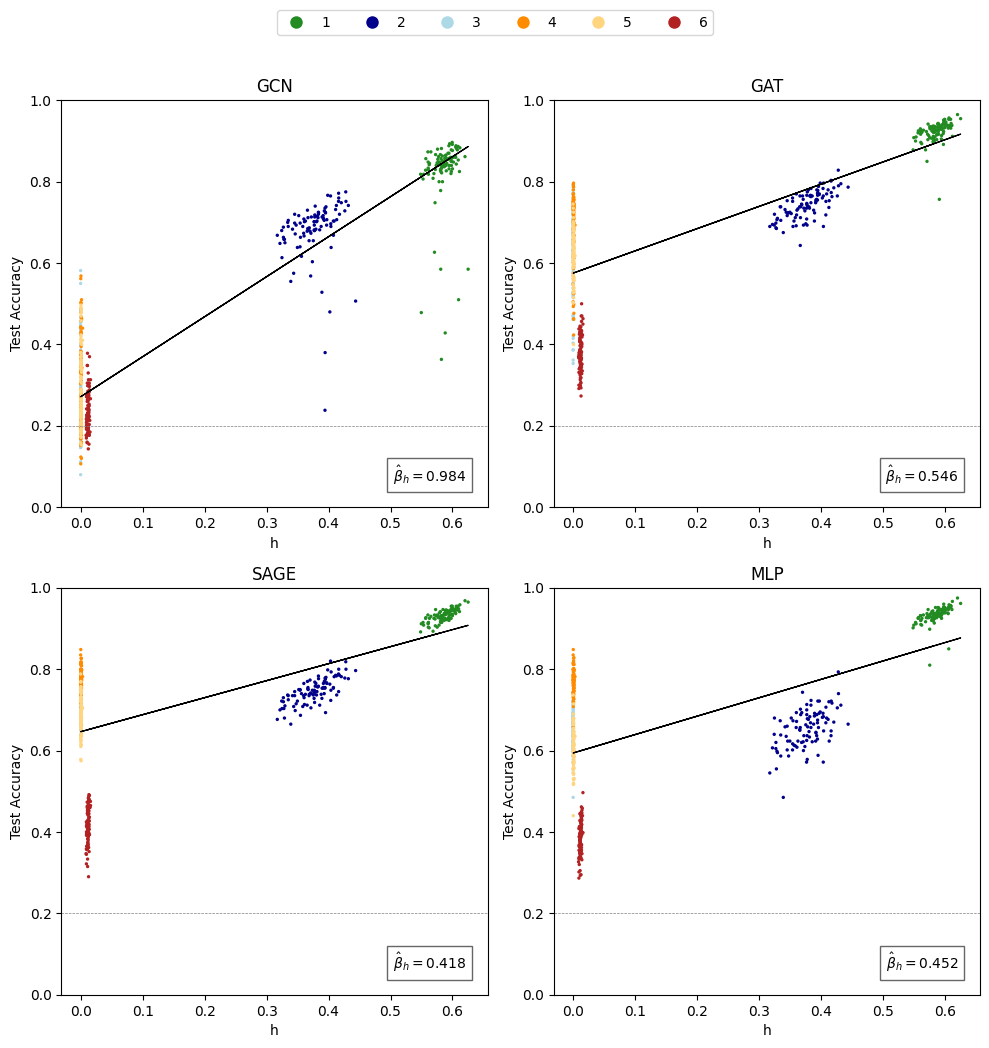

In [28]:
plot_scatter_relation(x1, Y, colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"], xlab = "h", R=100) 

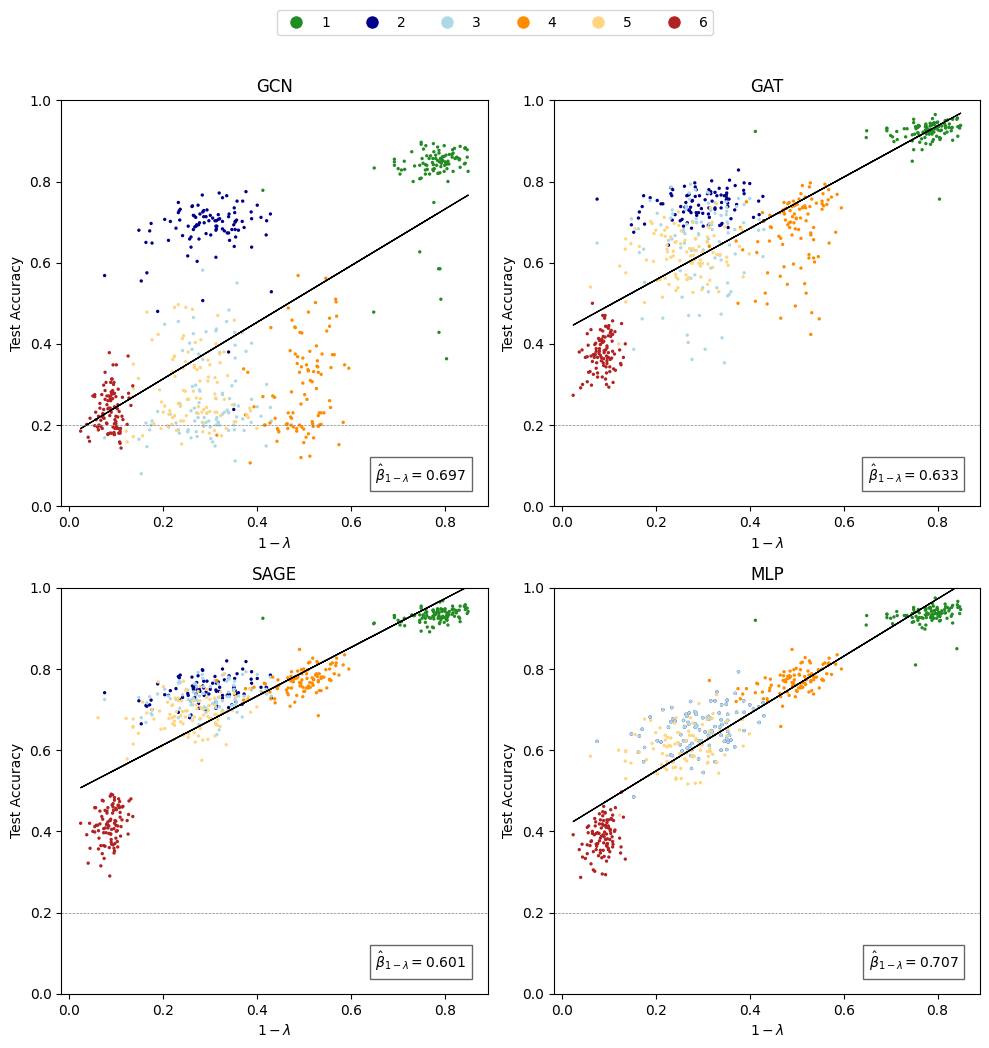

In [29]:
plot_scatter_relation(x2, Y, colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"], xlab = r"$1 - \lambda$", R=100)

In [31]:
for i,mod in enumerate(["GCN", "GAT", "SAGE", "MLP"]):
    X = np.column_stack((x1, x2))  
    X = sm.add_constant(X)         
    y = Y[i,:,:].flatten()
    
    ols_model = sm.OLS(y, X).fit()
    
    robust_model = ols_model.get_robustcov_results(cov_type='HC3')  
    
    print(mod)
    print("ß0 - ß_h - ß_l")
    print(np.round(robust_model.params, 4))
    print(np.round(robust_model.pvalues, 4))
    print("-"*20)

GCN
ß0 - ß_h - ß_l
[0.2625 0.962  0.0338]
[0.     0.     0.1348]
--------------------
GAT
ß0 - ß_h - ß_l
[0.4543 0.2535 0.4579]
[0. 0. 0.]
--------------------
SAGE
ß0 - ß_h - ß_l
[0.4986 0.0605 0.5591]
[0. 0. 0.]
--------------------
MLP
ß0 - ß_h - ß_l
[ 4.071e-01 -2.000e-04  7.073e-01]
[0.     0.9899 0.    ]
--------------------
